# Linear Regression

In this notebook I show various different ways to implement linear regression in Python. I start with the quick & easy way of using common packages to compute the regression parameters and then I demonstrate three ways to manually compute them from scratch. The dataset used is from [Andrew Ng's great machine learning course](https://www.coursera.org/learn/machine-learning), where I also learned two of the manual approaches (normal equations and gradient descent), which I implement in Python rather than Octave/MATLAB.

Regression answers the question of whether we can predict some outcome $y$ from some predictor or set of predictors $X$. It is defined as:

\begin{equation*}
\hat{y} = \beta_0 + \beta_1x_1 + \cdots + \beta_nx_n
\end{equation*}

To implement it, the $\beta$ coefficients must be solved for. These tell us by how much we should scale $x$ by in order to predict the value of $y$ for that given value of $x$.

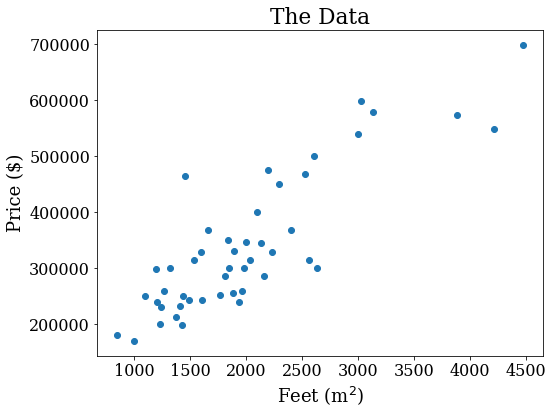

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='serif', size=18)
plt.rc('xtick', labelsize='16')
plt.rc('ytick', labelsize='16')

path = r'C:\Users\L\Documents\GitHub'
data = np.loadtxt(fname=f'{path}//ex1data2.txt', delimiter=',')

X = data[:, 0] # Just using the first column.
y = data[:, -1]

def plot(X, y, title=None):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(X, y)
    ax.set_xlabel('Feet (m$^2$)'), ax.set_ylabel('Price ($)')
    ax.set_title(title)
    return ax

ax = plot(X,y, 'The Data')
plt.show()

After solving for the coefficients, we are able to calculate the model's predictions of $y$ for every value of $x$ in our dataset, which then gives us a regression line.

## Python Packages for Regression

Python has several libraries that allow us to run linear regression, and the main choices are `Scipy`,`Scikit-Learn`, and `statsmodels`.

### Scipy

In [2]:
from scipy import stats

In [3]:
# Set the data
X = data[:, 0]
y = data[:, -1]

In [4]:
model = stats.linregress(X, y)
print(model)

LinregressResult(slope=134.52528772024132, intercept=71270.49244872911, rvalue=0.8549875928781253, pvalue=2.0272680958766845e-14, stderr=12.164967291909832)


This output is minimal, but has all of the key information that we're often after. We can now predict $y$:

In [5]:
def predict(x, beta0, beta1):
    return beta0 + (beta1 * x)

In [6]:
b0, b1 = model.intercept, model.slope
spprediction = predict(3500, b0, b1)
print(f"Scipy model predicts (y|x={3500}) = ${spprediction}")

Scipy model predicts (y|x=3500) = $542108.9994695737


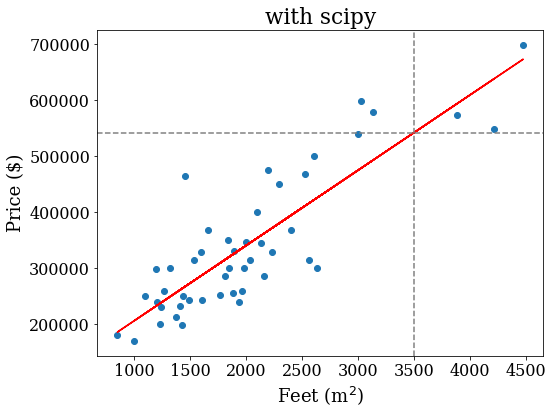

(Prediction shown in dashed grey line)


In [7]:
ax = plot(X, y, 'with scipy')
ax.plot(X, predict(X, b0, b1), c='r') # Modeling y for each value of X
ax.axhline(spprediction, c='grey', ls='dashed')
ax.axvline(3500, c='grey', ls='dashed')
plt.show()
print("(Prediction shown in dashed grey line)")

The only drawback with the `scipy` approach is that it cannot regress multiple variables of $X$, and so is only useful for cases of simple linear regression.

### Scikit-Learn

In [8]:
from sklearn import linear_model

In [9]:
X = data[:, 0].reshape(-1, 1)
y = data[:, -1].reshape(-1, 1)
m = len(y)
# X = np.c_[np.ones(m), X]
lm = linear_model.LinearRegression()
model = lm.fit(X,y)

In [10]:
# Print the beta coefficients 
model.intercept_, model.coef_

(array([71270.49244873]), array([[134.52528772]]))

In [11]:
skprediction = model.predict(np.array([[3500]])).item()
print(f"Scikit-Learn model predicts (y|x={3500}) = ${skprediction}")

Scikit-Learn model predicts (y|x=3500) = $542108.9994695737


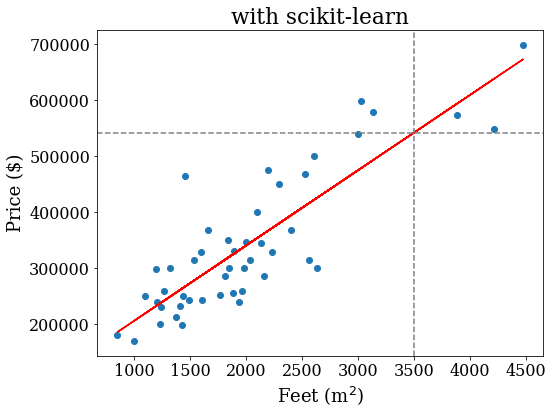

In [12]:
ax = plot(X, y, 'with scikit-learn')

ax.plot(X, lm.predict(X), color='red')
ax.axhline(skprediction, c='grey', ls='dashed')
ax.axvline(3500, c='grey', ls='dashed')
plt.show()

### Statsmodels

In [13]:
import statsmodels.api as sm

In [14]:
X = data[:, 0].reshape(-1, 1)
y = data[:, -1].reshape(-1, 1)

In [15]:
X = sm.add_constant(X) # statsmodels has a function to add the constant

model = sm.OLS(y, X).fit()
y_pred = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     122.3
Date:                Tue, 21 Jan 2020   Prob (F-statistic):           2.03e-14
Time:                        11:34:04   Log-Likelihood:                -586.94
No. Observations:                  47   AIC:                             1178.
Df Residuals:                      45   BIC:                             1182.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.127e+04   2.61e+04      2.725      0.009    1.86e+04    1.24e+05
x1           134.5253     12.165     11.058      0.000     110.024     159.027
==============================================================================
Omnibus:                        3.751   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.153   Jarque-Bera (JB):                2.726
Skew:                           0.557   Prob(JB):                        0.256
Kurtosis:                       3.390   Cond. No.                     5.88e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## How to Manually Calculate Regression

Despite there being many pre-built Python packages to perform regression, here is how to do it manually in three different ways.

## Approach 1: Old School

This is not especially practical, but it is quite helpful for learning purposes. This is how I first learned to calculate regression.

In [16]:
X = data[:, 0].reshape(-1, 1)
y = data[:, -1].reshape(-1, 1)

mean_x = np.mean(X)
mean_y = np.mean(y)

We first solve for $\beta_1$, as follows:
\begin{equation*}
\beta_1 = \frac{\sum_{i=1}^{m}(x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^{m}(x_i - \bar{x})^2}
\end{equation*}

So the numerator is the sum of the $x$ and $y$ covariance; the denominator is the sum of squared $x$ errors. Once we know $\beta_1$, we can solve for $\beta_0$ as:
\begin{equation*}
\beta_0 = \bar{y} - \beta_1x_1
\end{equation*}

So to solve for our $\beta$ values and find the line, we perform the following steps:
- Calculate the errors for $x$ and $y$
- Square the $x$ errors (this is our denominator)
- Calculate the *covariance* of $x$ and $y$ (which is the product of x errors and y errors; this is the numerator)
- Solve for $\beta_1$
- Solve for $\beta_0$

In [17]:
xerrs = X - np.mean(X)
yerrs = y - np.mean(y)

# Determine b1
xerrs_2 = xerrs**2
cov = xerrs * yerrs
b1 = np.sum(cov)/np.sum(xerrs_2) # 0.6, slope

# Determine b0
b0 = np.mean(y) - (b1*np.mean(X))

In [18]:
print(b0, b1)

71270.49244872906 134.52528772024135


Now we can use the $\beta$ coefficients to predict new values of $y$ from input values of $x$. We can also draw the line to plot by inputting all values of $x$ into the equation:

In [19]:
def predict(x, beta0, beta1):
    return beta0 + (beta1 * x)

oldschool_pred = predict(np.array([3500]), b0, b1).item() # For 3500 m^2 feet
print(f"Old school calculation model predicts (y|x={3500}) = ${oldschool_pred}")

Old school calculation model predicts (y|x=3500) = $542108.9994695738


And now we can find our best fitting line again, passing through that intersection.

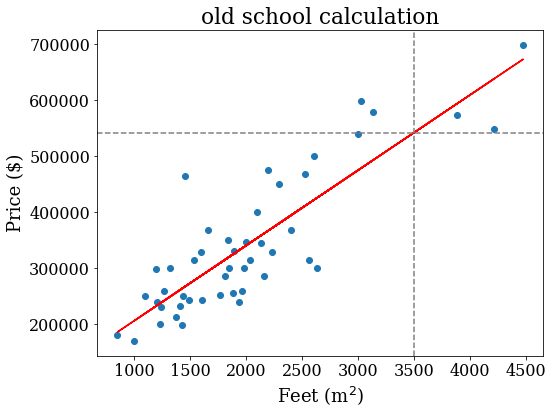

In [20]:
ax = plot(X, y, 'old school calculation')
# Plot the line
ax.plot(X, predict(X, b0, b1), c='red')
ax.axhline(oldschool_pred, c='grey', ls='dashed')
ax.axvline(3500, c='grey', ls='dashed')
plt.show()

## Approach 2: The Normal Equations

A more practical approach is to use the normal equations, which involves adding an intercept column (column of ones) to the $X$ matrix and leveraging matrix multiplication to quickly solve for our parameters of $\beta$:

\begin{equation*}
\beta = (X^TX)^{-1}X^Ty
\end{equation*}

In [21]:
X = data[:, 0].reshape(-1, 1)
y = data[:, -1].reshape(-1, 1)

In [22]:
# Add intercept to X
X = np.c_[np.ones(len(y)), X]

In [23]:
def normal_eqn(X, y):
    return np.linalg.pinv(X.T @ X) @ X.T @ y

In [24]:
betas = normal_eqn(X, y)
print(betas)

[[71270.49244796]
 [  134.52528772]]


In [25]:
y_preds = predict(X, betas[0].item(), betas[1].item())

In [26]:
neqn_pred = predict(np.array([3500]), betas[0].item(), betas[1].item())
print(f"Normal equations model predicts (y|x={3500}) = ${neqn_pred}")

Normal equations model predicts (y|x=3500) = $[542108.99946997]


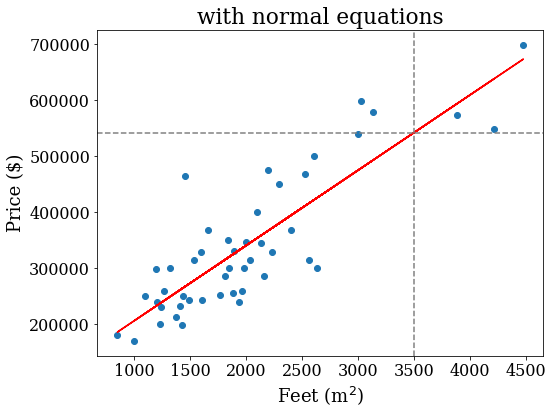

In [27]:
ax = plot(X[:, 1], y, 'with normal equations')
ax.plot(X[:, 1], y_preds[:, 1], c='r')
ax.axhline(neqn_pred, c='grey', ls='dashed')
ax.axvline(3500, c='grey', ls='dashed')
plt.show()

## Approach 3: Gradient Descent

Gradient descent is an iterative algorithm that solves for the regression coefficients (in this context, $\theta$ rather than $\beta$) by minimising the error (cost, $J$) between a proposed 'guess' at the coefficients (the hypothesis, $h$) and the observed values of $y$ across a specified number of iterations. The steps are:<br>
- Initialise coefficients (typically at zero) to form the initial hypothesis $h$
- Compute the cost, $J$ (the error of the current $h$)
- If the cost is too high, reduce the coefficients; if it is too low, increase them.
- Repeat until convergence.

In this context, we form our hypothesis $h$ as:

\begin{equation*}
h_\theta(x) = \theta_0 + \theta_1x_1
\end{equation*}
<br>
Note that this is just the equation for regression anyway. Then we must compute the cost for this particular hypothesis, which is given by the following formula:
\begin{equation*}
J(\theta_0, \theta_1) = 
\frac{1}{2m}\sum_{i=1}^{m}
(\hat{y}_i - y_i)^2 = 
\frac{1}{2m}\sum_{i=1}^{m}
(h_\theta(x_i) - y_i)^2
\end{equation*}

This cost function $J$ essentially computes the mean squared error of each hypothesis that we come up with. Then, the parameters of $\theta$ are updated, the cost recomputed, and the process repeated until convergence.

In [28]:
X = data[:, 0].reshape(-1, 1)
y = data[:, -1].reshape(-1, 1)
m = len(y)

If we normalise our $X$ to be in a common space, gradient descent converges faster.

In [29]:
def normalise(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0, ddof=1)
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma

In [30]:
# Normalise X
X, mu, sigma = normalise(X)

Just like with the normal equations approach, we must add an intercept column to $X$ - this is due to the fact that we are making use of matrix multiplication to more effectively make the calculations.

In [31]:
# Add the intercept
X = np.c_[np.ones(m), X]
n = X.shape[1]

Now we can initialise our $\theta$ parameters (essentially just $\beta$ values). Since there is no reason to use any particular values for this, it is conventional to start at zero:

In [32]:
# Initialise theta parameters
theta = np.zeros((n, 1))

In [33]:
# Some gradient descent settings
iterations = 500
alpha = 0.01 # This is the learning rate - the extent to which we adjust theta after each iteration

In [34]:
# Functions for gradient descent
def compute_cost(X, y, theta):
    m = y.shape[0]
    h = X @ theta
    J = 1 / (2*m) * np.sum((h - y)**2)
    return J

def gradient_descent(X, y, theta, alpha, n_iterations):
    
    m = y.shape[0]
    J_history = []#np.zeroes((n_iterations, 1))
    
    for i in range(n_iterations):
        h = X @ theta
        theta -= alpha * (1 / m) * (X.T @ (h - y))
        J_history.append(compute_cost(X, y, theta))
    
    return theta, J_history

def plot_cost(J):
    fig, ax = plt.subplots()
    ax.plot(range(len(J)), J)
    ax.set_xlabel('iteration')
    ax.set_ylabel('Cost J')
    plt.show()
    return

def gdpredict(to_predict, mu, sigma, theta):
    normed = (to_predict - mu)/sigma
    normed = np.insert(normed, 0, 1)
    prediction = normed @ theta
    return prediction.item()

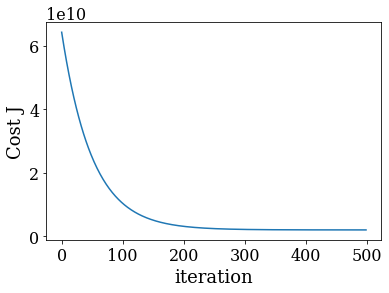

In [35]:
# Run the gradient descent algorithm
theta, J_history = gradient_descent(X,y,theta,alpha,iterations)
plot_cost(J_history)
gdprediction = gdpredict(np.array([3500]), mu, sigma, theta)

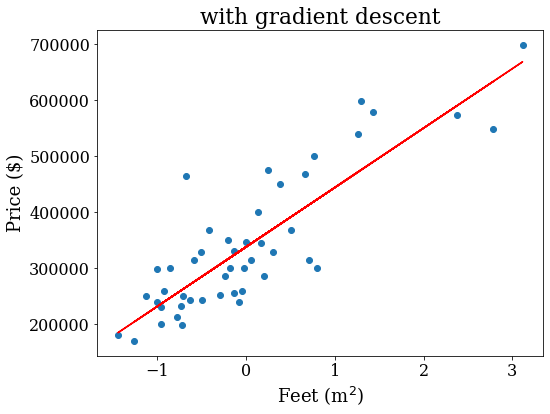

In [36]:
ax = plot(X[:, 1], y, 'with gradient descent')
ax.plot(X[:, 1], X@theta, c='r')
plt.show()

Remember that $X$ was normalised, so the scale is different and our $\theta$ parameters will also be different.

In [37]:
print("Theta computed from gradient descent: \n")
print(theta)
print()

print(f'Predicted price of a 1650 sq-ft, 3 br house (using gradient descent):${gdprediction}')

Theta computed from gradient descent: 

[[338175.98396731]
 [106125.45078465]]

Predicted price of a 1650 sq-ft, 3 br house (using gradient descent):$538396.7582526186


Notice that the coefficient values predicted by gradient descent also differ more than the others - this is simply because of the number of iterations chosen. We can increase the iterations to show that it gradually converges:

In [38]:
# Run the gradient descent algorithm again with more iterations
theta, J_history = gradient_descent(X,y,theta,alpha,n_iterations=5000)

print("Theta computed from gradient descent: \n")
print(theta)
print()

gdprediction = gdpredict(np.array([3500]), mu, sigma, theta)
print(f'Predicted price of a 1650 sq-ft, 3 br house (using gradient descent):${gdprediction}')

Theta computed from gradient descent: 

[[340412.65957447]
 [106907.5627611 ]]

Predicted price of a 1650 sq-ft, 3 br house (using gradient descent):$542108.9994695694


The gradient descent method is typically only really important for linear regression when the variable space of $X$ becomes larger than 5,000 to 10,000 and is probably overkill for many simple cases. HOWEVER: Gradient descent is really important for other machine learning algorithms.